In [10]:
import csv
import pandas as pd
import clip
import torch
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
from PIL import Image
from scipy.spatial.distance import cdist
import bisect 
from scipy.spatial import ConvexHull
import gc
import debias_clip as dclip
import copy
import sklearn.feature_selection as fs
#import cvxpy as cp
image_folder_prefix = 'datasets/gender_in_image_search/google/'

data = pd.read_csv('datasets/gender_in_image_search/gender_labelled_images.csv')

In [3]:
## Preprocessing

catagories = data['search_term'].unique()
data['image_relative_path'] = data['image_url'].str.replace("http://homes.cs.washington.edu/~mjskay/aws-images/google/", image_folder_prefix)

C:\Users\Alexa\AppData\Local\Temp\ipykernel_23804\436016921.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data['image_relative_path'] = data['image_url'].str.replace("http://homes.cs.washington.edu/~mjskay/aws-images/google/", image_folder_prefix)


In [69]:
data.head(10)


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device)

batch_size = 200

features = process_images(model, preprocess, data['image_relative_path'], batch_size=batch_size)



100%|██████████| 17/17 [00:20<00:00,  1.21s/it]


In [5]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
device_d = 'cpu'
model_debias, preprocess_debias = dclip.load("ViT-B/16-gender", device_d)

batch_size = 200

features_debias = process_images(model_debias, preprocess_debias, data['image_relative_path'], batch_size=batch_size, device=device_d)

Installing pretrained embedings
 best_ndkl_oai-clip-vit-b-16_neptune_run_OXVLB-317_model_e4_step_5334_embeddings.pt...


100%|█████████████████████████████████████| 4.73k/4.73k [00:00<00:00, 4.88MiB/s]
 47%|████▋     | 8/17 [07:55<08:55, 59.49s/it]


KeyboardInterrupt: 

In [6]:
device_d = "cuda" if torch.cuda.is_available() else "cpu"
model_debias, preprocess_debias = dclip.load("ViT-B/16-gender", device_d)

batch_size = 200

features_debias = process_images(model_debias, preprocess_debias, data['image_relative_path'], batch_size=batch_size, device=device_d)

device_d = 'cpu'
model_debias, preprocess_debias = dclip.load("ViT-B/16-gender", device_d)
    



Installing pretrained embedings
 best_ndkl_oai-clip-vit-b-16_neptune_run_OXVLB-317_model_e4_step_5334_embeddings.pt...


100%|█████████████████████████████████████████████| 4.73k/4.73k [00:00<?, ?iB/s]
100%|██████████| 17/17 [00:57<00:00,  3.37s/it]


Installing pretrained embedings
 best_ndkl_oai-clip-vit-b-16_neptune_run_OXVLB-317_model_e4_step_5334_embeddings.pt...


100%|█████████████████████████████████████| 4.73k/4.73k [00:00<00:00, 3.44MiB/s]


In [63]:
class ImageDatabase():
    def __init__(self, features, data, model, preprocess, device="cuda"):
        if device == "cuda": self.arraytype = torch.float16 
        else: self.arraytype = torch.float32
        self.features = t_normalize(torch.tensor(features).to(device)).to(self.arraytype)
        self.data = data
        self.model = model
        self.preprocess = preprocess
        self.device = device
        self.clipclip_orderings = {}

    def _process_query(self, query):
        token = clip.tokenize(query).to(self.device)
        #print(token.device)
        with torch.no_grad():
            query_features = t_normalize(self.model.encode_text(token))
        return query_features
        
    def search(self, query, k=10, **kwargs):
        query_features = self._process_query(query)
        similarities = (self.features @ query_features.T).flatten()
        best = similarities.argsort(descending=True).cpu().flatten()
        return self.data.iloc[best[:k]]
    
    def sensitive_attributes(self, paired_attributes):
        l_attr = list(sum(paired_attributes, ()))
        tokens = clip.tokenize(l_attr).to(self.device)
        with torch.no_grad():
            attributes_features = t_normalize(self.model.encode_text(tokens))
        self.sensitive_ideals = attributes_features.reshape(len(paired_attributes), 2, -1)

        return self
        
    def _calc_sim_set(self, best, similarities, k, max_sim_set, tol):
        sim = similarities[best]
        sim_top_k_avg = sim[0:k].mean()
        for i in range(len(sim)):
            if sim[i] < sim_top_k_avg - tol:
                break
        k = min(max(k, i), max_sim_set)
        return best[0:k]


    def _get_sim_to_ideal(self, entries):
        sim_set_features = self.features[entries]
        sim = torch.matmul(self.sensitive_ideals, sim_set_features.T)
        proba = (100 * sim).permute(2, 0, 1).softmax(dim=-1)[:, :, 0].to('cpu').numpy()
        return proba

    def _retrieve_distinct(self, sim_set, similarities, k, mode='max_sum'):
        proba_concepts = self._get_sim_to_ideal(sim_set)
        vals = proba_concepts
        pca = PCA()
        
        if mode == 'max_sum': 
            VI=np.cov(vals, rowvar=False)
            sim_set_edit = sim_set.detach().clone().numpy()
            p_indices = [sim_set_edit[0]]
            sim_set_edit = np.delete(sim_set_edit, 0)
            p = [vals[0]]
            vals = np.delete(vals, 0, axis=0)

            distances = cdist(vals, p, 'mahalanobis', VI=VI)

            while len(p) < k:
                mean_distances = np.mean(distances, axis=1)
                max_sum = np.argmax(mean_distances)
                maximally_away = max_sum
                p_indices.append(sim_set_edit[maximally_away])
                p.append(vals[maximally_away])
                distances = np.hstack((distances, cdist(vals, [vals[maximally_away]], 'mahalanobis', VI=VI)))
                sim_set_edit = np.delete(sim_set_edit, maximally_away)
                vals = np.delete(vals, maximally_away, axis=0)
                distances = np.delete(distances, maximally_away, axis=0)

        if mode == 'max_min':
            VI=np.cov(vals, rowvar=False)
            sim_set_edit = sim_set.detach().clone().numpy()
            p_indices = [sim_set_edit[0]]
            sim_set_edit = np.delete(sim_set_edit, 0)
            p = [vals[0]]
            vals = np.delete(vals, 0, axis=0)

            distances = cdist(vals, p, 'mahalanobis', VI=VI)

            while len(p) < k:
                min_distances = np.min(distances, axis=1)
                max_min = np.argmax(min_distances)
                maximally_away = max_min
                p_indices.append(sim_set_edit[maximally_away])
                p.append(vals[maximally_away])
                distances = np.hstack((distances, cdist(vals, [vals[maximally_away]], 'mahalanobis', VI=VI)))
                sim_set_edit = np.delete(sim_set_edit, maximally_away)
                vals = np.delete(vals, maximally_away, axis=0)
                distances = np.delete(distances, maximally_away, axis=0)

        if mode == 'random':
            p_indices = np.random.choice(sim_set, k, replace = False)

        if mode == "feature_distances":
            vals = torch.index_select(self.features, 0, sim_set.to(self.device)).cpu().numpy()
            sim_set_edit = sim_set.detach().clone().numpy()
            p_indices = [sim_set_edit[0]]
            sim_set_edit = np.delete(sim_set_edit, 0)
            p = [vals[0]]
            vals = np.delete(vals, 0, axis=0)

            distances = cdist(vals, p, 'cosine')

            while len(p) < k:
                mean_distances = np.mean(distances, axis=1)
                max_sum = np.argmax(mean_distances)
                maximally_away = max_sum
                p_indices.append(sim_set_edit[maximally_away])
                p.append(vals[maximally_away])
                distances = np.hstack((distances, cdist(vals, [vals[maximally_away]], 'cosine')))
                sim_set_edit = np.delete(sim_set_edit, maximally_away)
                vals = np.delete(vals, maximally_away, axis=0)
                distances = np.delete(distances, maximally_away, axis=0)

        if mode == 'true_labels':
            vals = self._get_true_coordinates(sim_set)
            VI=np.cov(vals, rowvar=False)
            sim_set_edit = sim_set.detach().clone().numpy()
            p_indices = [sim_set_edit[0]]
            sim_set_edit = np.delete(sim_set_edit, 0)
            p = [vals[0]]
            vals = np.delete(vals, 0, axis=0)

            distances = cdist(vals, p, 'mahalanobis', VI=VI)

            while len(p) < k:
                mean_distances = np.mean(distances, axis=1)
                max_sum = np.argmax(mean_distances)
                maximally_away = max_sum
                p_indices.append(sim_set_edit[maximally_away])
                p.append(vals[maximally_away])
                distances = np.hstack((distances, cdist(vals, [vals[maximally_away]], 'mahalanobis', VI=VI)))
                sim_set_edit = np.delete(sim_set_edit, maximally_away)
                vals = np.delete(vals, maximally_away, axis=0)
                distances = np.delete(distances, maximally_away, axis=0)

        return p_indices
    
    def define_coordinate_mapping(self, columns, positive_labels, negative_labels):
        self.true_coordinates = np.zeros((len(self.data), len(columns)))
        self.coord_columns = columns
        for i, column in enumerate(columns):
            map_to_hypercube = lambda x: 1 if x in positive_labels[i] else (0 if x in negative_labels[i] else .5)
            self.true_coordinates[:, i] = self.data[column].apply(map_to_hypercube)
    
    def _get_true_coordinates(self, sim_set):
        return self.true_coordinates[sim_set] 

    
    def distinct_retrival(self, query, k=10, max_sim_set=1000, tol=.06, method='max_sum', **kwargs) :
        query_features = self._process_query(query)

        similarities = (self.features @ query_features.T).flatten()
        best = similarities.argsort(descending=True).cpu().flatten()

        sim_set = self._calc_sim_set(best, similarities, k, max_sim_set, tol)
        distinct_sort = self._retrieve_distinct(sim_set, similarities, k, mode=method)


        return self.data.iloc[distinct_sort]

    def define_pbm_classes(self, classes):
        self.pbm_classes=classes
        prompts = [f"A picture of a {c}." for c in classes]
        if classes[0] == "empty":
            prompts[0] == ""
        tokens = clip.tokenize(prompts).to(self.device)
        with torch.no_grad():
            attributes_features = t_normalize(self.model.encode_text(tokens))
        self.pbm_ideals = attributes_features
        self.pbm_label = np.argmax((100 * torch.matmul(self.features, self.pbm_ideals.T)).softmax(dim=-1).to('cpu').numpy(), axis=-1)

        return self

    def pbm(self, query, k=10, eps=0, **kwargs):
        query_features = self._process_query(query)
        similarities = (self.features @ query_features.T).flatten()
        best = similarities.argsort(descending=True).cpu().numpy().flatten()
        np_sim = similarities.cpu().numpy()

        p_indices = []

        neutrals = [x for x in best if self.pbm_label[x] == 0]
        classes = [[x for x in best if self.pbm_label[x]== i] for i in range(1, len(self.pbm_classes))]

        

        while len(p_indices) < k:
            if random.random() < eps:
                try:
                    neutral_sim = np_sim[neutrals[0]]
                except:
                    neutral_sim = -1
                
                max_class, idx = 0, 0
                for i, c in enumerate(classes):
                    try:
                        class_sim = np_sim[c[0]]
                    except:
                        class_sim = -1
                    if class_sim > max_class:
                        max_class = class_sim
                        idx = i
                if max_class > neutral_sim:
                    p_indices.append(classes[idx][0])
                    classes[idx].pop(0)
                else:
                    p_indices.append(neutrals[0])
                    neutrals.pop(0)
            else:
                best_neutral = neutrals[0]
                best_for_classes = [fon(c) for c in classes]
                best_for_classes_vals = [c for c in best_for_classes if c is not None]

                similarities_for_classes = [np_sim[x] for x in best_for_classes_vals]
                avg_sim = np.mean(similarities_for_classes)
                neutral_sim = similarities[best_neutral]

                if avg_sim > neutral_sim:
                    if len(p_indices) + len(best_for_classes_vals) > k:
                        best_for_classes_vals = random.choices(best_for_classes_vals, k=k-len(p_indices))
                    p_indices += best_for_classes_vals

                    for i, x in enumerate(best_for_classes):
                        if x is not None:
                            classes[i].pop(0)
                else:
                    p_indices.append(best_neutral)
                    neutrals.pop(0)
        
        return self.data.iloc[p_indices]
    
    def add_clipclip_ordering(self, name, ordering):
        self.clipclip_orderings[name] = ordering.copy()
        return self
    
    def clip_clip(self, query, ordering, n_to_clip, k=10, **kwargs):
        query_features = self._process_query(query)
        clip_ordering = self.clipclip_orderings[ordering]
        print(clip_ordering[n_to_clip:])
        clip_features = torch.index_select(self.features, 1, torch.tensor(clip_ordering[n_to_clip:]).to(self.device))
        print(clip_features.shape)
        clip_query = torch.index_select(query_features, 1, torch.tensor(clip_ordering[n_to_clip:]).to(self.device))
        print(clip_query.shape)

        similarities = (clip_features @ clip_query.T).flatten()
        print(similarities.shape)
        best = similarities.argsort(descending=True).cpu().flatten()
        return self.data.iloc[best[:k]]



In [67]:
image_database = ImageDatabase(features, data, model, preprocess, device)
image_database.sensitive_attributes([("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person"), ("A picture of a young person", "A picture of an old person")])

#print(image_database.search("This is a picture of a engineer."))
print(image_database.distinct_retrival("This is a picture of a pilot.", method='feature_distances', k=10))

#image_database.define_pbm_classes(["unknown gender", "man", "woman"])
#print(image_database.pbm("This is a picture of a customer service representative.", eps=0))

#debias_database = ImageDatabase(features_debias, data, model_debias, preprocess_debias, device_d)
#debias_database.search("This is a picture of a engineer.")


#image_database.define_coordinate_mapping(['image_gender'], [['man']], [['woman']])
#print(image_database.true_coordinates)
#print(image_database.data['image_gender'])
#print(image_database.distinct_retrival("This is a picture of a pilot.", method='true_labels'))



#image_database.add_clipclip_ordering("gender", ord)
#image_database.clip_clip("This is a picture of a pilot", "gender", 350, k=10)

     search_term    bls_n  bls_women  search_n  search_women  bls_p_women  \
94         pilot   129000       5289        77             8        0.041   
2040       pilot   129000       5289        77             8        0.041   
1397       pilot   129000       5289        77             8        0.041   
1473   announcer    50000      11800        86            18        0.236   
1142  bus driver   558000     253890        48             9        0.455   
2976       pilot   129000       5289        77             8        0.041   
1395    optician    54000      32184        70            48        0.596   
2131       nurse  2875000    2604750        89            86        0.906   
819        pilot   129000       5289        77             8        0.041   
2539       pilot   129000       5289        77             8        0.041   

      search_p_women Answer.typeofpeople Answer.howmany  multiple_onegender  \
94          0.103896                 man      oneperson               Fal

In [45]:
print(ord.shape)



(512,)


tensor([[ 0.2544,  0.2952, -0.7983,  ..., -0.4170, -0.4500,  0.0721],
        [ 0.0569, -0.4702, -0.8608,  ...,  0.2280, -0.5669,  0.5186],
        [ 0.1064, -0.6265, -1.1943,  ..., -0.4409, -0.2659,  0.1592],
        ...,
        [ 0.3621,  0.1116, -1.4316,  ..., -0.1882, -0.3845,  0.2141],
        [ 0.6216,  0.6147, -2.0527,  ...,  0.0039,  0.3052, -0.1709],
        [-0.3892,  0.0697,  0.3633,  ...,  0.3545, -0.0690,  0.2067]],
       dtype=torch.float16)

In [8]:
def run_analysis(method_call, k, tol, result_dict, catagories, catagorical_column, label_indistinguishable_values_list, protected_columns, protected_positive_values, protected_negative_values, true_rates, totals_by_cat, prefix="This is a picture of a"):
    result_dict['k'] = k
    result_dict['tol'] = tol
    result_dict['precision'] = np.zeros(len(catagories))
    result_dict['precision_up_to_indistinguishablity'] = np.zeros(len(catagories))
    result_dict['recall'] = np.zeros(len(catagories))
    result_dict['bias'] = np.zeros((len(catagories), len(protected_columns)))
    result_dict['abs_bias'] = np.zeros((len(catagories), len(protected_columns)))
    result_dict['skew'] = np.zeros((len(catagories), len(protected_columns)))
    result_dict['bias_for_accurate'] = np.zeros((len(catagories), len(protected_columns)))
    result_dict['abs_bias_for_accurate'] = np.zeros((len(catagories), len(protected_columns)))
    result_dict['skews_for_accurate'] = np.zeros((len(catagories), len(protected_columns)))
    result_dict['max_skew'] = np.zeros(len(catagories))
    result_dict['min_skew'] = np.zeros(len(catagories))
    result_dict['worst_multiclass_error'] = np.zeros(len(catagories))



    for i, cat in enumerate(catagories):
        res = method_call(f"{prefix} {cat}")
        result_dict['precision'][i] = precision(label_column=catagorical_column, positive_label_value=cat, data=res)
        result_dict['precision_up_to_indistinguishablity'][i] = precision_up_to_indistinguishablity(label_column=catagorical_column, indistinguishable_labels=label_indistinguishable_values_list[i], data=res)
        result_dict['recall'][i] = recall(label_column=catagorical_column, positive_label_value=cat, data=res, total_positive=totals_by_cat[cat])
        biases = np.zeros(len(protected_columns))
        skews = np.zeros(len(protected_columns))
        abs_biases = np.zeros(len(protected_columns))
        biases_for_accurate = np.zeros(len(protected_columns))
        abs_biases_for_accurate = np.zeros(len(protected_columns))
        skews_for_accurate = np.zeros(len(protected_columns))

        for j, (protected_col, protected_pos_vals, protected_neg_vals) in enumerate(zip(protected_columns, protected_positive_values, protected_negative_values)):
            abs_bias, abs_bias_in_correct_retrievals = abs_bias_in_retrieval(label_column=catagorical_column, positive_label_values=[cat], data=res, protected_column=protected_col, protected_positive_values=protected_pos_vals, protected_negative_values=protected_neg_vals)
            bias, bias_in_correct_retrievals = bias_in_retrieval(label_column=catagorical_column, positive_label_values=[cat], data=res, protected_column=protected_col, protected_positive_values=protected_pos_vals, protected_negative_values=protected_neg_vals)
            biases[j] = bias
            biases_for_accurate[j] = bias_in_correct_retrievals
            abs_biases[j] = abs_bias
            abs_biases_for_accurate[j] = abs_bias_in_correct_retrievals
            skew, skew_for_accurate = skew_in_retrieval(label_column=catagorical_column, positive_label_values=[cat], data=res, protected_column=protected_col, protected_positive_values=protected_pos_vals, true_rate=true_rates[j][i])
            skews[j] = skew
            skews_for_accurate[j] = skew_for_accurate
        
        result_dict['bias'][i] = biases
        result_dict['abs_bias'][i] = abs_biases
        result_dict['skew'][i] = skews
        result_dict['bias_for_accurate'][i] = biases_for_accurate
        result_dict['abs_bias_for_accurate'][i] = abs_biases_for_accurate
        result_dict['skews_for_accurate'][i] = skews_for_accurate
        result_dict['max_skew'][i] = max(skews)
        result_dict['min_skew'][i] = min(skews)
        result_dict['worst_multiclass_error'][i] = multiclass_bias_in_retrieval(label_column=catagorical_column, positive_label_values=[cat], data=res, protected_columns=protected_columns, protected_positive_values=protected_positive_values, protected_negative_values=protected_negative_values)

    return result_dict

def parse_analysis(result_dicts, protected_column_names):
    data = []
    for result in result_dicts:
        parsed_result = {}
        if result['tol'] is not None:
            if result['name'][0:3] == "PBM":
                parsed_result['method'] = result['name'] + "(eps " + str(result['tol']) + ")"
            parsed_result['method'] = result['name'] + " (tol: " + str(result['tol']) + ")"
        else:
            parsed_result['method'] = result['name']
        parsed_result['name'] = result['name']
        parsed_result['tol'] = result['tol']
        parsed_result['k'] = result['k']
        parsed_result['Avg_Precision'] = np.mean(result['precision'])
        parsed_result['Avg_Recall'] = np.mean(result['recall'])
        parsed_result['Avg_PutI'] = np.mean(result['precision_up_to_indistinguishablity'])

        for i, protected_col in enumerate(protected_column_names):
            parsed_result[f'Avg_AbsBias_{protected_col}'] = np.mean(result['abs_bias'][:,i])
            parsed_result[f'Avg_Bias_{protected_col}'] = np.mean(result['bias'][:,i])
            parsed_result[f'Avg_Skew_{protected_col}'] = np.mean(result['skew'][:,i])
            parsed_result[f'Avg_Abs_Skew_{protected_col}'] = np.mean(np.abs(result['skew'][:,i]))
            parsed_result[f'Avg_AbsBias_for_Accurate_{protected_col}'] = np.mean(result['abs_bias_for_accurate'][:,i])

        parsed_result['Avg_Max_MC_Bias'] =np.mean(result['worst_multiclass_error'])

        if len(protected_column_names) > 1:
            parsed_result['Max_AbsBias'] = np.max([np.mean(result['abs_bias'][:,i]) for i in range(len(protected_column_names))])

        data.append(parsed_result.copy())

    df = pd.DataFrame(data)
    return df

image_database = ImageDatabase(features, data, model, preprocess, device)
image_database.sensitive_attributes([("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person")]) #
image_database.define_pbm_classes(["unknown gender", "man", "woman"])
debias_database = ImageDatabase(features_debias, data, model_debias, preprocess_debias, device_d)

baseline_metrics = {'name': 'Baseline'}
random_from_similar_set_metrics = {'name': 'RandomSS'}
divimage_max_sum_metrics = {'name': 'DivImageMSum'}
divimage_max_min_metrics = {'name': 'DivImageMMin'}
#diviamge_clustering_metrics = {'name': 'DivImageC'}
#divimage_qp_metrics = {'name': 'DivImageQP'}
random_from_similar_set_metrics_larger_tol = {'name': 'RandomSS'}
divimage_max_sum_metrics_larger_tol = {'name': 'DivImageMSum'}
divimage_max_min_metrics_larger_tol = {'name': 'DivImageMMin'}
pbm_metrics = {'name': 'PBM'}
pbm_intersectional_metrics = {'name': 'PBM_Intersectional'}
debias_clip_metrics = {'name': 'DebiasClip'}
true_labels = {'name': 'TrueConceptLabels'}
true_labels_larger_tol = {'name': 'TrueConceptLabels'}


indistinguisable_values = [[cat] for cat in catagories]
true_rates = [[data[data['search_term'] == cat].iloc[0].search_p_women for cat in catagories]]
totals_by_cat = {cat: len(data[data['search_term'] == cat]) for cat in catagories}
image_database.define_coordinate_mapping(['image_gender'], [['man']], [['woman']])

run_analysis(lambda x: image_database.search(x, 25), 25, None, baseline_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
run_analysis(lambda x: image_database.distinct_retrival(x, 25, tol=.02, method='max_sum'), 25, .02, divimage_max_sum_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
run_analysis(lambda x: image_database.distinct_retrival(x, 25, tol=.02, method='max_min'), 25, .02, divimage_max_min_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
run_analysis(lambda x: image_database.distinct_retrival(x, 25, tol=.02, method='random'), 25, .02, random_from_similar_set_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
run_analysis(lambda x: image_database.distinct_retrival(x, 25, tol=.04, method='max_sum'), 25, .04, divimage_max_sum_metrics_larger_tol, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
run_analysis(lambda x: image_database.distinct_retrival(x, 25, tol=.04, method='max_min'), 25, .04, divimage_max_min_metrics_larger_tol, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
run_analysis(lambda x: image_database.distinct_retrival(x, 25, tol=.04, method='random'), 25, .04, random_from_similar_set_metrics_larger_tol, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
run_analysis(lambda x: image_database.pbm(x, 25, eps=0), 25, None, pbm_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
image_database.define_pbm_classes(["unknown gender and skin-tone", "light-skinned man", "light-skinned woman", "dark-skinned man", "dark-skinned woman"])
run_analysis(lambda x: image_database.pbm(x, 25, eps=0), 25, None, pbm_intersectional_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
run_analysis(lambda x: debias_database.search(x, 25), 25, None, debias_clip_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
run_analysis(lambda x: image_database.distinct_retrival(x, 25, tol=.02, method='true_labels'), 25, .02, true_labels, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
run_analysis(lambda x: image_database.distinct_retrival(x, 25, tol=.04, method='true_labels'), 25, .04, true_labels_larger_tol, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)


df = parse_analysis([baseline_metrics, divimage_max_sum_metrics, divimage_max_min_metrics, random_from_similar_set_metrics, divimage_max_sum_metrics_larger_tol, divimage_max_min_metrics_larger_tol, random_from_similar_set_metrics_larger_tol, pbm_metrics, pbm_intersectional_metrics, debias_clip_metrics, true_labels, true_labels_larger_tol], ['gender'])
"""plt.hist(baseline_metrics['precision'] - divimage_metrics['precision'])
plt.show()

plt.hist(baseline_metrics['bias'] - divimage_metrics['bias'])
plt.show()"""

#print(f"Baseline Average Bias: {np.mean(baseline_metrics['bias'])}, DivImage Average Bias: {np.mean(divimage_metrics['bias'])}")

#print(divimage_metrics['bias'])
print(df)

                           method                name   tol   k  \
0                        Baseline            Baseline   NaN  25   
1        DivImageMSum (tol: 0.02)        DivImageMSum  0.02  25   
2        DivImageMMin (tol: 0.02)        DivImageMMin  0.02  25   
3            RandomSS (tol: 0.02)            RandomSS  0.02  25   
4        DivImageMSum (tol: 0.04)        DivImageMSum  0.04  25   
5        DivImageMMin (tol: 0.04)        DivImageMMin  0.04  25   
6            RandomSS (tol: 0.04)            RandomSS  0.04  25   
7                             PBM                 PBM   NaN  25   
8              PBM_Intersectional  PBM_Intersectional   NaN  25   
9                      DebiasClip          DebiasClip   NaN  25   
10  TrueConceptLabels (tol: 0.02)   TrueConceptLabels  0.02  25   
11  TrueConceptLabels (tol: 0.04)   TrueConceptLabels  0.04  25   

    Avg_Precision  Avg_Recall  Avg_PutI  Avg_AbsBias_gender  Avg_Bias_gender  \
0        0.562667    0.207950  0.562667         

In [30]:
def calc_feature_MI(features, labels, n_neighbors = 10, rs=1):
    return fs.mutual_info_classif(features, labels, discrete_features=False, copy=True, n_neighbors=n_neighbors, random_state=rs)

def return_feature_MI_order(features, data, sensitive_attributes, n_neighbors = 10, rs=1):
    labels = data[sensitive_attributes].apply(lambda x: ' '.join(x), axis=1) 
    print(labels)
    feature_MI = calc_feature_MI(features, labels, n_neighbors, rs)
    print(feature_MI)
    feature_order = np.argsort(feature_MI)[::-1]
    print(feature_MI[feature_order])
    return feature_order

ord = return_feature_MI_order(features, data, ['image_gender'])

print(ord)

0       woman
1         man
2         man
3         man
4         man
        ...  
3257      man
3258      man
3259    woman
3260    woman
3261      man
Length: 3262, dtype: object
[0.00000000e+00 3.87142000e-03 1.91317163e-02 1.64907882e-02
 9.49270030e-03 1.12148758e-02 4.47312266e-03 2.03583380e-02
 1.10346368e-02 1.86667648e-04 8.16626831e-04 3.62853726e-03
 3.98188250e-03 2.23206765e-02 4.24616406e-03 0.00000000e+00
 7.52978025e-02 3.21726285e-03 6.98949508e-02 4.85670179e-03
 9.03203516e-03 0.00000000e+00 0.00000000e+00 3.53772322e-03
 1.29898035e-02 7.49105536e-03 2.07836451e-02 3.21196420e-02
 7.64638872e-03 5.34165362e-03 1.94762717e-02 7.28252873e-03
 1.74197222e-02 5.46450171e-02 0.00000000e+00 0.00000000e+00
 5.24456374e-03 4.22269281e-02 5.30703777e-03 3.97966682e-02
 5.77575301e-04 1.17727730e-03 1.75720372e-03 1.02663298e-02
 1.18523965e-02 4.03718898e-03 3.09729804e-03 8.99047866e-03
 3.64764194e-02 1.55019755e-02 3.34913484e-02 0.00000000e+00
 4.76376569e-03 0.0000000

In [ ]:
### For precision-bias and recall-bias graphs --

number_of_tol_steps = 15
methods = [
    'max_sum', 'max_min', 'random', 'true_labels', 'PBM_gender', 'PBM_skintone', 'PBM_intersectional'
]

#methods = ['PBM', 'PBM_Intersectional']

image_database = ImageDatabase(features, data, model, preprocess, device)
image_database.sensitive_attributes([("A picture of a man", "A picture of a woman"), ("A picture of a white person", "A picture of a black person")])

debias_database = ImageDatabase(features_debias, data, model_debias, preprocess_debias, device_d)

totals_by_cat = {cat: len(data[data['search_term'] == cat]) for cat in catagories}
image_database.define_coordinate_mapping(['image_gender'], [['man']], [['woman']])

random_iters = 5

for k in [10, 25, 50, 100]:
    print(f"Starting analysis for k: {k}...")
    precisions, biases, skews, abs_biases, abs_bias_for_accurate = {}, {}, {}, {}, {}

    #max_skew = []
    #min_skew = []

    for method in methods:
        print(f"Method: {method}...")
        avg_precision = []
        avg_bias = []
        avg_skew = []
        avg_abs_bias = []
        avg_abs_bias_for_accurate = []
        if method[0:3] == 'PBM':
            if method == 'PBM_gender':
                image_database.define_pbm_classes(["unknown gender", "man", "woman"])
            elif method == 'PBM_skintone':
                image_database.define_pbm_classes(["unknown skin-tone", "light-skinned person", "dark-skinned person"])
            elif method == 'PBM_intersectional':
                image_database.define_pbm_classes(["unknown gender and skin-tone", "light-skinned man", "light-skinned woman", "dark-skinned man", "dark-skinned woman"])
            for eps in tqdm(reversed(range(0, 11))):
                mean_precision = 0
                mean_bias = 0
                mean_skew = 0
                mean_abs_bias = 0
                mean_abs_average_bias_for_accurate = 0
                for i in range(random_iters):
                    baseline_metrics = {}
                    run_analysis(lambda x: image_database.pbm(x, k, eps=eps/10), k, None, baseline_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates)
                    mean_precision += np.mean(baseline_metrics['precision'])
                    mean_bias += np.mean(baseline_metrics['bias'])
                    mean_abs_bias += np.mean(baseline_metrics['abs_bias'])
                    mean_skew += np.mean(baseline_metrics['skew'])
                    mean_abs_average_bias_for_accurate += np.mean(baseline_metrics['abs_bias_for_accurate'])

                avg_precision.append(mean_precision / random_iters)
                avg_bias.append(mean_bias / random_iters)
                avg_skew.append(mean_skew / random_iters)
                avg_abs_bias.append(mean_abs_bias / random_iters)
                avg_abs_bias_for_accurate.append(mean_abs_average_bias_for_accurate / random_iters)
                gc.collect()
                torch.cuda.empty_cache()

        else:
            for tol in tqdm(range(0, number_of_tol_steps)):
                baseline_metrics = {}
                gc.collect()
                torch.cuda.empty_cache()
                t = tol / (10 * (number_of_tol_steps-1))
                ## This is inefficient write a faster way to vary tol and rerun the analysis
                if method == 'random':
                    mean_precision = 0
                    mean_bias = 0
                    mean_skew = 0
                    mean_abs_bias = 0
                    mean_abs_average_bias_for_accurate = 0
                    for i in range(random_iters):
                        baseline_metrics = {}
                        run_analysis(lambda x: image_database.distinct_retrival(x, k, tol=t, method=method), k, t, baseline_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates)
                        mean_precision += np.mean(baseline_metrics['precision'])
                        mean_bias += np.mean(baseline_metrics['bias'])
                        mean_skew += np.mean(baseline_metrics['skew'])
                        mean_abs_bias += np.mean(baseline_metrics['abs_bias'])
                        mean_abs_average_bias_for_accurate += np.mean(baseline_metrics['abs_bias_for_accurate'])
                    avg_precision.append(mean_precision/random_iters)
                    avg_bias.append(mean_bias/random_iters)
                    avg_skew.append(mean_skew/random_iters)
                    avg_abs_bias.append(mean_abs_bias/random_iters)
                    avg_abs_bias_for_accurate.append(mean_abs_average_bias_for_accurate/random_iters)

                    gc.collect()
                    torch.cuda.empty_cache()
                else:
                    run_analysis(lambda x: image_database.distinct_retrival(x, k, tol=t, method=method), k, t, baseline_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates)
                    avg_precision.append(np.mean(baseline_metrics['precision']))
                    avg_bias.append(np.mean(baseline_metrics['bias']))
                    avg_skew.append(np.mean(baseline_metrics['skew']))
                    avg_abs_bias.append(np.mean(baseline_metrics['abs_bias']))
                    avg_abs_bias_for_accurate.append(np.mean(baseline_metrics['abs_bias_for_accurate']))
                
                #max_skew.append(np.mean(divimage_metrics['max_skew']))
                #min_skew.append(np.mean(divimage_metrics['min_skew']))
        precisions[method] = avg_precision
        biases[method] = avg_bias
        skews[method] = avg_skew
        abs_biases[method] = avg_abs_bias
        abs_bias_for_accurate[method] = avg_abs_bias_for_accurate

    print("Computing Baseline...")
    baseline_metrics = {}
    run_analysis(lambda x: image_database.search(x, k), k, None, baseline_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates)
    baseline_precision = np.mean(baseline_metrics['precision'])
    baseline_bias = np.mean(baseline_metrics['bias'])
    baseline_skew = np.mean(baseline_metrics['skew'])
    baseline_abs_bias = np.mean(baseline_metrics['abs_bias']) 
    baseline_abs_bias_for_accurate = np.mean(baseline_metrics['abs_bias_for_accurate'])


    print("Computing Debias-Prompt...")
    debias_metrics = {}
    run_analysis(lambda x: debias_database.search(x, k), k, None, debias_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates)
    debias_precision = np.mean(debias_metrics['precision'])
    debias_bias = np.mean(debias_metrics['bias'])
    debias_skew = np.mean(debias_metrics['skew'])
    debias_abs_bias = np.mean(debias_metrics['abs_bias'])
    debias_abs_bias_for_accurate = np.mean(debias_metrics['abs_bias_for_accurate'])

    for method in methods:
        plt.plot(biases[method], precisions[method], label=method)
    plt.scatter(baseline_bias, baseline_precision, label='Baseline', color = 'black')
    plt.scatter(debias_bias, debias_precision, label='Debias', color = 'red')
    plt.grid()
    plt.xlabel("Average Bias")
    plt.ylabel("Average Precision")
    #plt.gca().invert_xaxis()
    plt.title(f"Precision-Bias Curve @ {k}")
    plt.legend()
    plt.show()

    for method in methods:
        plt.plot(abs_biases[method], precisions[method], label=method)
    plt.scatter(baseline_abs_bias, baseline_precision, label='Baseline', color = 'black')
    plt.scatter(debias_abs_bias, debias_precision, label='Debias', color = 'red')
    plt.grid()
    plt.xlabel("Average AbsBias")
    plt.ylabel("Average Precision")
    plt.gca().invert_xaxis()
    plt.title(f"Precision-AbsBias Curve @ {k}")
    plt.legend()
    plt.show()

    for method in methods:
        plt.plot(abs_bias_for_accurate[method], precisions[method], label=method)
    plt.scatter(baseline_abs_bias_for_accurate, baseline_precision, label='Baseline', color = 'black')
    plt.scatter(debias_abs_bias_for_accurate, debias_precision, label='Debias', color = 'red')
    plt.grid()
    plt.xlabel("Average AbsBias for Accurate")
    plt.ylabel("Average Precision")
    plt.gca().invert_xaxis()
    plt.title(f"Precision-AbsBias Curve for Accurate Labels @ {k}")
    plt.legend()
    plt.show()


    for method in methods:
        plt.plot(skews[method], precisions[method], label=method)
    plt.scatter(baseline_skew, baseline_precision, label='Baseline', color='black')
    plt.scatter(debias_skew, debias_precision, label='Debias', color='red')
    plt.grid()
    plt.xlabel("Average Skew")
    plt.ylabel("Average Precision")
    plt.gca().invert_xaxis()
    plt.title(f"Precision-Skew Curve @ {k}")
    plt.legend()
    plt.show()

    for method in methods:
        plt.scatter(biases[method], skews[method], label=method)
    plt.scatter(baseline_bias, baseline_skew, label='Baseline', color='black')
    plt.scatter(debias_bias, debias_skew, label='Debias', color='red')
    plt.legend()
    plt.grid()
    plt.ylabel("Average Skew")
    plt.xlabel("Average Bias")
    plt.title(f"Bias-Skew Scatter @ {k}")
    plt.show()




In [48]:
attr = [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person"), ("A picture of a young person", "A picture of an old person"), ("A picture of an American Person", "A picture of a non-American person"), ("A picture of a disabled person", "A picture of a person who is not disabled")]
image_database = ImageDatabase(features, data, model, preprocess, device)
totals_by_cat = {cat: len(data[data['search_term'] == cat]) for cat in catagories}
image_database.define_coordinate_mapping(['image_gender'], [['man']], [['woman']])

ks = [10, 25, 50]
number_of_tol_steps = 20

for k in ks:
    precisions, biases, recalls = {}, {}, {}
    for i in tqdm(range(len(attr))):
        avg_precision = []
        avg_bias = []
        avg_recall = []
        image_database.sensitive_attributes(attr[:i+1])
        for tol in range(0, number_of_tol_steps):
            baseline_metrics = {}
            t = tol / (200)
            run_analysis(lambda x: image_database.distinct_retrival(x, k, tol=t, method='max_sum'), k, t, baseline_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
            avg_precision.append(np.mean(baseline_metrics['precision']))
            avg_bias.append(np.mean(baseline_metrics['abs_bias']))
            avg_recall.append(np.mean(baseline_metrics['recall']))
        precisions[str(i)] = avg_precision
        biases[str(i)] = avg_bias
        recalls[str(i)] = avg_recall


    baseline_metrics = {}
    run_analysis(lambda x: image_database.search(x, k), k, None, baseline_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
    baseline_precision = np.mean(baseline_metrics['precision'])
    baseline_bias = np.mean(baseline_metrics['abs_bias'])
    baseline_recall = np.mean(baseline_metrics['recall'])

    for i in range(len(attr)):
        plt.plot(biases[str(i)], precisions[str(i)], label=("Total unmeasured cats: " + str(i)))
    plt.scatter(baseline_bias, baseline_precision, label='Baseline')
    plt.grid()
    plt.xlabel("Average AbsBias")
    plt.ylabel("Average Precision")
    plt.gca().invert_xaxis()
    plt.title(f"Precision-AbsBias Curve @ {k}")
    plt.legend()
    plt.show()

    for i in range(len(attr)):
        plt.plot(biases[str(i)], recalls[str(i)], label=("Total unmeasured cats: " + str(i)))
    plt.scatter(baseline_bias, baseline_recall, label='Baseline')
    plt.grid()
    plt.xlabel("Average AbsBias")
    plt.ylabel("Average Recall")
    plt.gca().invert_xaxis()
    plt.title(f"Recall-AbsBias Curve @ {k}")
    plt.legend()
    plt.show()

    for i in range(len(attr)):
        plt.plot(recalls[str(i)], precisions[str(i)], label=("Total unmeasured cats: " + str(i)))
    plt.scatter(baseline_bias, baseline_recall, label='Baseline')
    plt.grid()
    plt.xlabel("Average Recall")
    plt.ylabel("Average Precision")
    plt.title(f"Precision-Recall Curve @ {k}")
    plt.legend()
    plt.show()

            

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [04:28<17:52, 268.02s/it]


KeyboardInterrupt: 

In [69]:

image_database = ImageDatabase(features, data, model, preprocess, device)
totals_by_cat = {cat: len(data[data['search_term'] == cat]) for cat in catagories}
image_database.define_coordinate_mapping(['image_gender'], [['man']], [['woman']])

"""method_name_specification_list = [
    (lambda k, tol: lambda x: image_database.search(x, k), 'Baseline', []),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_sum'), 'CDI_Sum_gender', [("sensitive_attributes", [("A picture of a man", "A picture of a woman")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_sum'), 'CDI_Sum_intersectional', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_sum'), 'CDI_Sum_skintone', [("sensitive_attributes", [("A picture of a light-skinned person", "A picture of a dark-skinned person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_min'), 'CDI_Min_gender', [("sensitive_attributes", [("A picture of a man", "A picture of a woman")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_min'), 'CDI_Min_intersectional', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_min'), 'CDI_Min_skintone', [("sensitive_attributes", [("A picture of a light-skinned person", "A picture of a dark-skinned person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='random'), 'CDI_Random', [("sensitive_attributes", [("A picture of a man", "A picture of a woman")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='true_labels'), 'CDI_TrueConcept', []),
    (lambda k, eps: lambda x: image_database.pbm(x, k, eps=eps), 'PBM_gender', [("pbm_classes", ["unknown gender", "man", "woman"])]),
    (lambda k, eps: lambda x: image_database.pbm(x, k, eps=eps), 'PBM_intersectional', [("pbm_classes", ["unknown gender and skin-tone", "light-skinned man", "light-skinned woman", "dark-skinned man", "dark-skinned woman"])]),
    (lambda k, eps: lambda x: image_database.pbm(x, k, eps=eps), 'PBM_skintone', [("pbm_classes", ["unknown skin-tone", "light-skinned person", "dark-skinned person"])]),
    (lambda k, tol: lambda x: debias_database.search(x, k), 'DebiasClip', [])
]"""

"""method_name_specification_list = [
    (lambda k, eps: lambda x: image_database.pbm(x, k, eps=eps), 'PBM_gender', [("pbm_classes", ["unknown gender", "man", "woman"])]),
    (lambda k, eps: lambda x: image_database.pbm(x, k, eps=eps), 'PBM_intersectional', [("pbm_classes", ["unknown gender and skin-tone", "light-skinned man", "light-skinned woman", "dark-skinned man", "dark-skinned woman"])]),
    (lambda k, eps: lambda x: image_database.pbm(x, k, eps=eps), 'PBM_skintone', [("pbm_classes", ["unknown skin-tone", "light-skinned person", "dark-skinned person"])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='feature_distances'), 'CDI_Features', [])
]"""

method_name_specification_list = [
    (lambda k, n: lambda x: image_database.clip_clip(x, "gender", n, k), 'CLIP_gender', []),
    (lambda k, n: lambda x: image_database.clip_clip(x, "skintone", n, k), 'CLIP_skintone', []),
    (lambda k, n: lambda x: image_database.clip_clip(x, "intersectional", n, k), 'CLIP_intersectional', []),
    (lambda k, n: lambda x: image_database.clip_clip(x, "three_attr", n, k), 'CLIP_three_attributes', [])
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_min'), 'CDI_Min_skintone', [("sensitive_attributes", [("A picture of a light-skinned person", "A picture of a dark-skinned person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='euc_max_sum'), 'CDI_EucSum_intersectional', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='euc_max_min'), 'CDI_EucMin_intersectional', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person")])])
]

ks = [10, 25, 50, 100]

number_of_tol_steps = 16
number_of_eps_steps = 11
random_iters = 4
number_of_clip_clip_steps = 24

result_dicts = []

for method, name, spec in method_name_specification_list:
    print(f"Starting analysis for method: {name}...")
    for s, val in spec:
        if s == "sensitive_attributes":
            image_database.sensitive_attributes(val)
        if s == "pbm_classes":
            image_database.define_pbm_classes(val)
    for k in tqdm(ks):
        result_dict = {'name': name}

        if name in ['Baseline', "DebiasClip"]:
            steps = 1
        else:
            steps = number_of_tol_steps

        if name[0:3] == 'PBM':
            for e in reversed(range(0, number_of_eps_steps)):
                eps = e / (number_of_eps_steps - 1)
                retrieval_function = method(k, eps)
                new_dict = result_dict.copy()
                random_results = []
                for i in range(random_iters):
                    new_dict = result_dict.copy()
                    run_analysis(retrieval_function, k, eps, new_dict, catagories, 'search_term', indistinguisable_values,  ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
                    random_results.append(new_dict)
                
                add_dict = result_dict.copy()
                for key in random_results[0].keys():
                    if key == 'name':
                        continue
                    add_dict[key] = np.mean([res[key] for res in random_results], axis=0)
                result_dicts.append(add_dict)
        
        elif name[0:4] == 'CLIP':
            for e in range(0, number_of_clip_clip_steps):
                n = e * 20
                retrieval_function = method(k, n)
                new_dict = result_dict.copy()
                run_analysis(retrieval_function, k, n, new_dict, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
                result_dicts.append(new_dict)

        else:
            for t in range(0, steps):
                if steps == 1:
                    tol = None
                else:
                    tol = t / 200
                retrieval_function = method(k, tol)
                new_dict = result_dict.copy()
                if name == "CDI_Random":
                    random_results = []
                    for i in range(random_iters):
                        new_dict = result_dict.copy()
                        run_analysis(retrieval_function, k, tol, new_dict, catagories, 'search_term', indistinguisable_values,  ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
                        random_results.append(new_dict)
                    new_dict = result_dict.copy()

                    for key in random_results[0].keys():
                        if key == 'name':
                            continue
                        new_dict[key] = np.mean([res[key] for res in random_results], axis=0)
                else:
                    run_analysis(retrieval_function, k, tol, new_dict, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
                result_dicts.append(new_dict)

df = parse_analysis(result_dicts, ['gender'])

print(df)

df.to_pickle("results/giis-3-24-CLIP-euc.pkl")
        

Starting analysis for method: CDI_Features...


100%|██████████| 4/4 [09:55<00:00, 148.86s/it]

                       method          name    tol    k  Avg_Precision  \
0     CDI_Features (tol: 0.0)  CDI_Features  0.000   10       0.655556   
1   CDI_Features (tol: 0.005)  CDI_Features  0.005   10       0.651111   
2    CDI_Features (tol: 0.01)  CDI_Features  0.010   10       0.637778   
3   CDI_Features (tol: 0.015)  CDI_Features  0.015   10       0.617778   
4    CDI_Features (tol: 0.02)  CDI_Features  0.020   10       0.611111   
..                        ...           ...    ...  ...            ...   
59  CDI_Features (tol: 0.055)  CDI_Features  0.055  100       0.119556   
60   CDI_Features (tol: 0.06)  CDI_Features  0.060  100       0.105333   
61  CDI_Features (tol: 0.065)  CDI_Features  0.065  100       0.096222   
62   CDI_Features (tol: 0.07)  CDI_Features  0.070  100       0.089556   
63  CDI_Features (tol: 0.075)  CDI_Features  0.075  100       0.085111   

    Avg_Recall  Avg_PutI  Avg_AbsBias_gender  Avg_Bias_gender  \
0     0.099015  0.655556            0.773333  

In [22]:
df2 = pd.read_pickle("results/giis-3-21.pkl")

print(df2)

                        method            name    tol      k  Avg_Precision  \
0                     Baseline        Baseline    NaN   10.0       0.655556   
1                     Baseline        Baseline    NaN   25.0       0.562667   
2                     Baseline        Baseline    NaN   50.0       0.485333   
3                     Baseline        Baseline    NaN  100.0       0.367333   
4    CDI_Sum_gender (tol: 0.0)  CDI_Sum_gender  0.000   10.0       0.655556   
..                         ...             ...    ...    ...            ...   
707    DebiasClip (tol: 0.055)      DebiasClip  0.055  100.0       0.437111   
708     DebiasClip (tol: 0.06)      DebiasClip  0.060  100.0       0.437111   
709    DebiasClip (tol: 0.065)      DebiasClip  0.065  100.0       0.437111   
710     DebiasClip (tol: 0.07)      DebiasClip  0.070  100.0       0.437111   
711    DebiasClip (tol: 0.075)      DebiasClip  0.075  100.0       0.437111   

     Avg_Recall  Avg_PutI  Avg_AbsBias_gender  Avg_

In [32]:
def plot_across_tol(df, k, method_names, axis1, axis2, xlabel=None, ylabel=None, title=None, reverse_x = False):
    relevant_k = df[df['k'] == k]

    for method in method_names:
        data_for_method = relevant_k[relevant_k['name'] == method]
        d1 = data_for_method[axis1]
        d2 = data_for_method[axis2]

        if method in ["Baseline", "DebiasClip"]:
            plt.scatter(d1, d2, label=method)
        else:
            plt.plot(d1, d2, label=method)
    plt.legend()
    if xlabel is not None:
        plt.xlabel(xlabel)
    else:
        plt.xlabel(axis1)
    if ylabel is not None:
        plt.ylabel(ylabel)
    else:
        plt.ylabel(axis2)
    if title is not None:
        plt.title(title)
    else:
        plt.title(f"Graph of {axis2} over {axis1}")
    if reverse_x:
        plt.gca().invert_xaxis()
    plt.grid()
    plt.show()



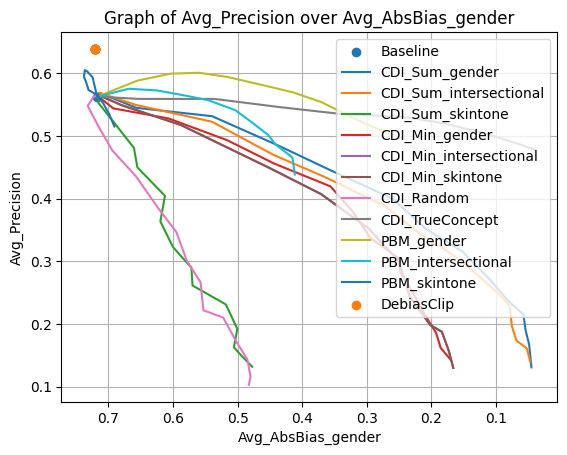

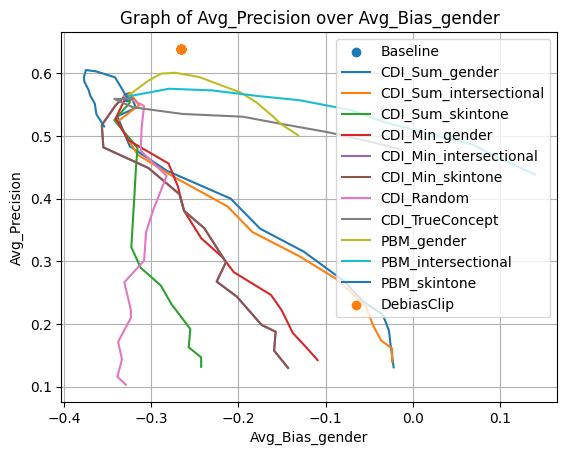

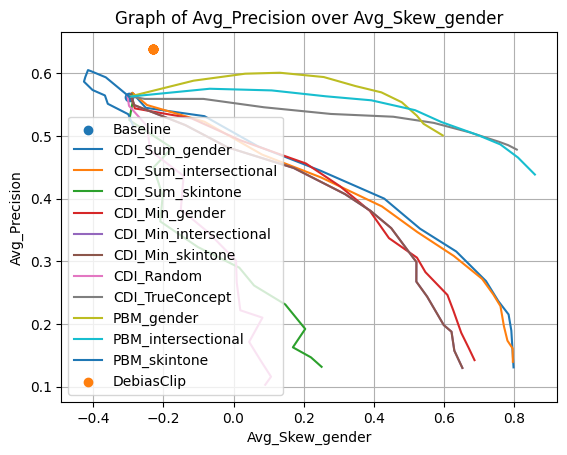

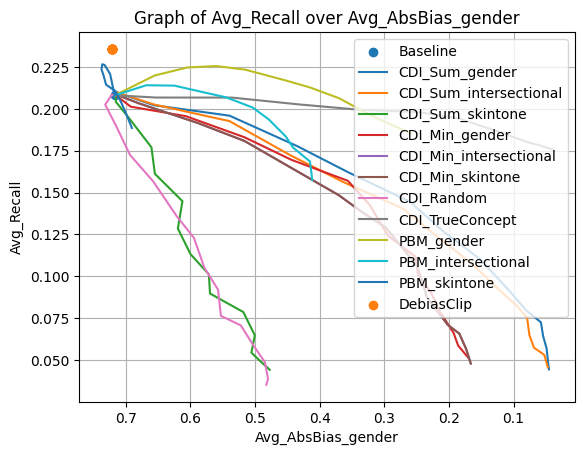

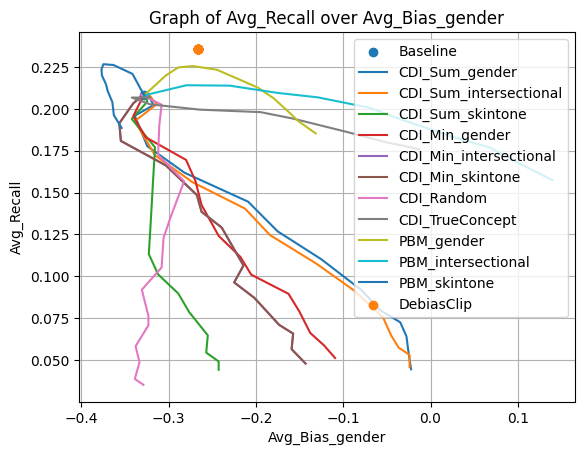

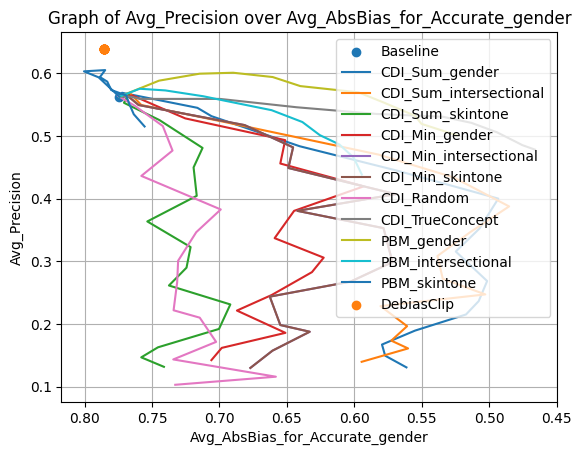

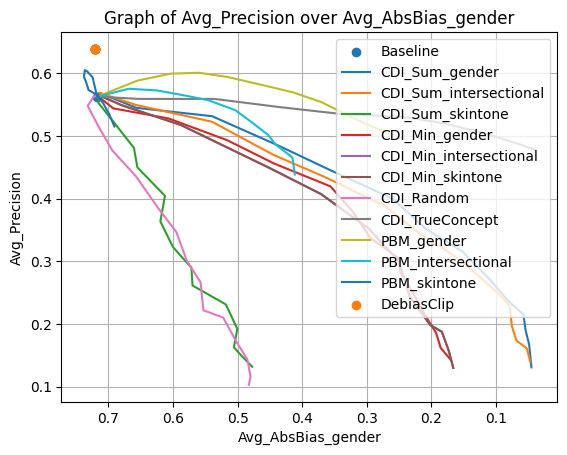

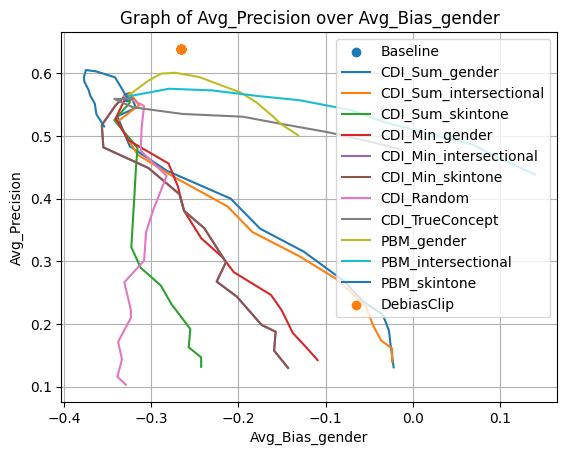

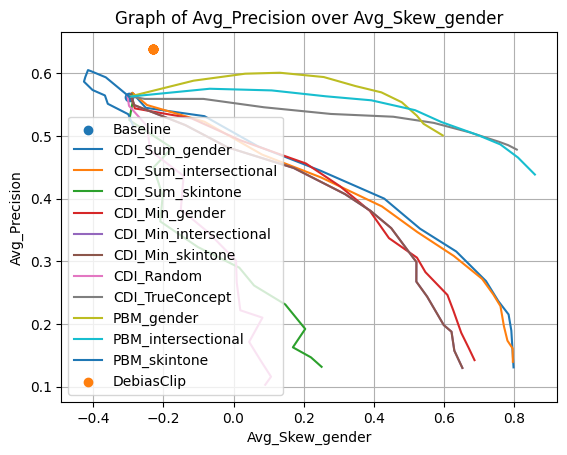

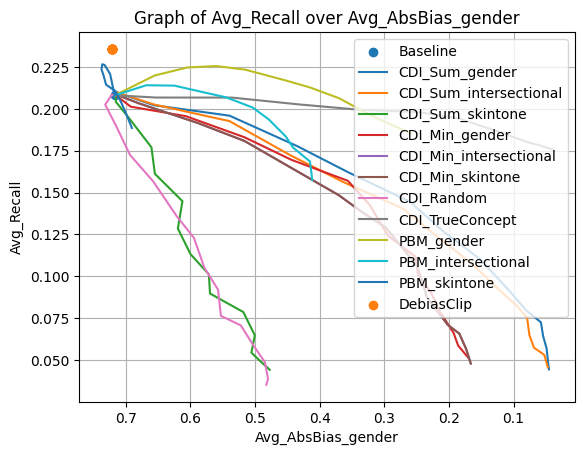

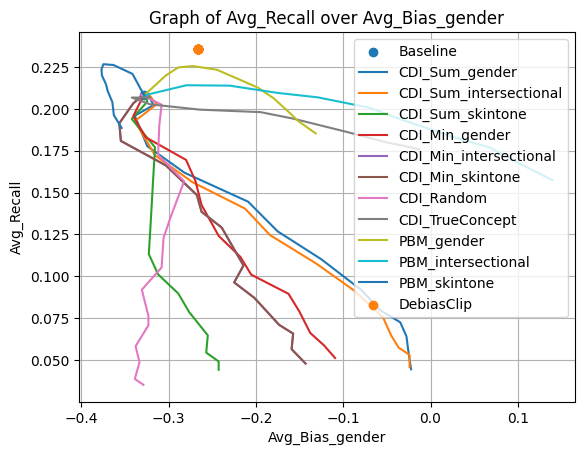

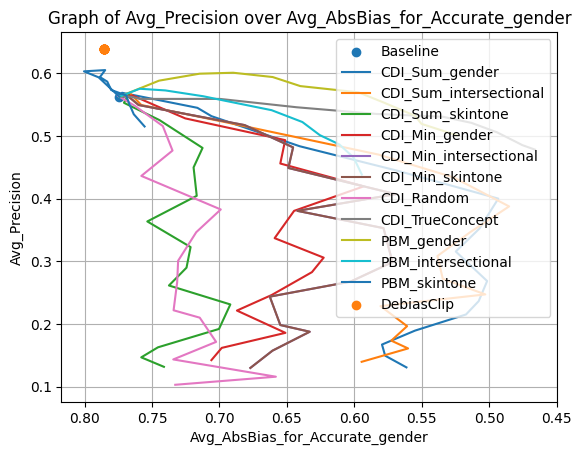

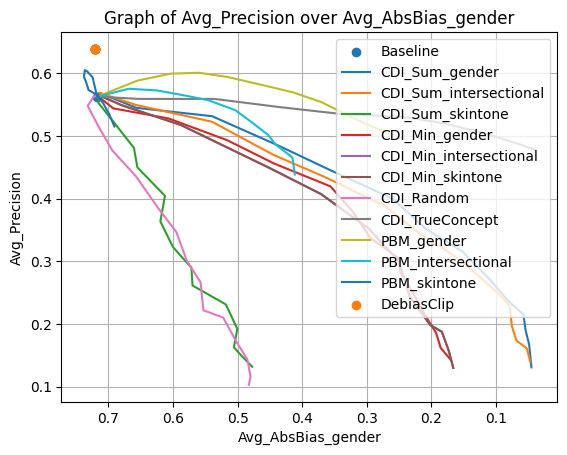

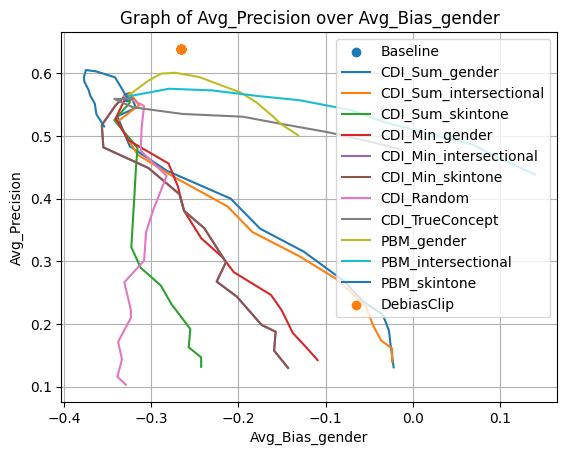

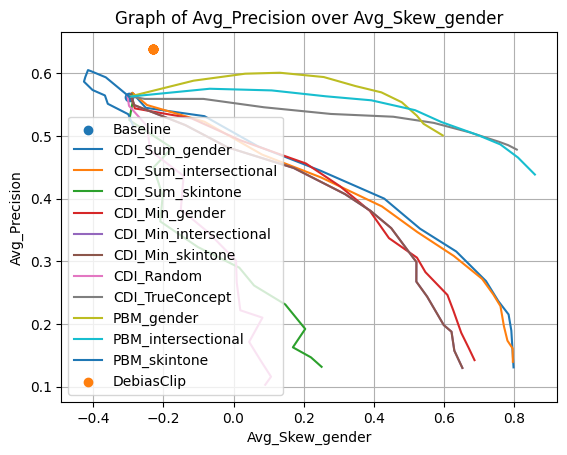

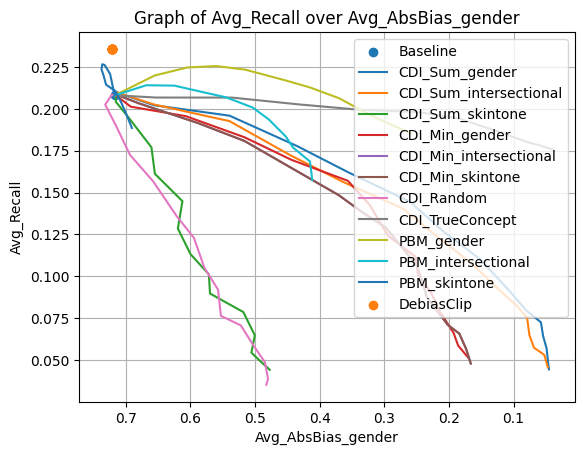

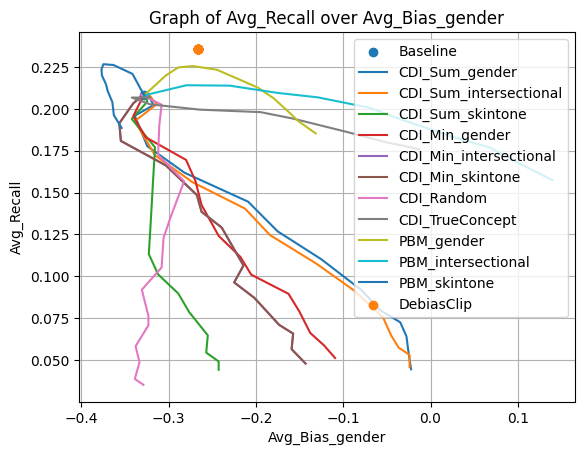

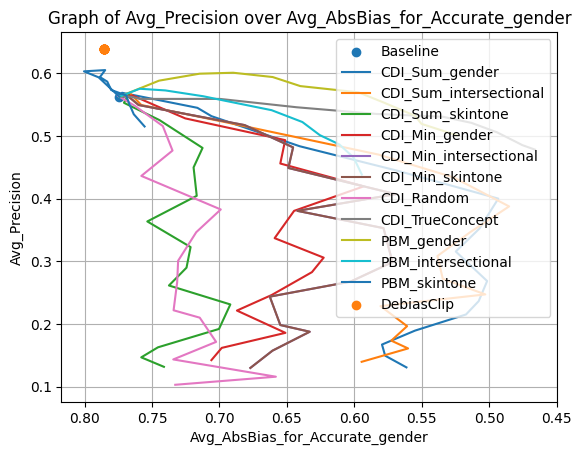

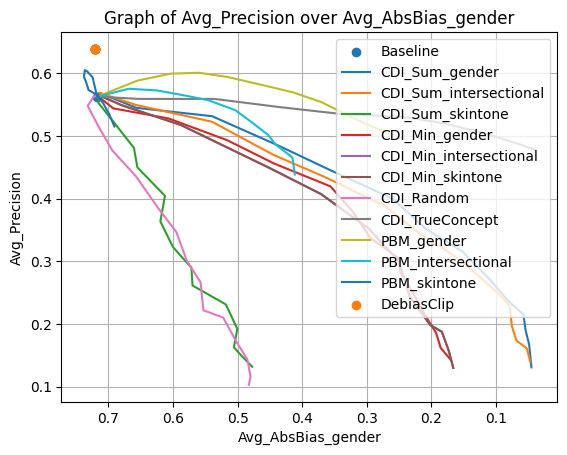

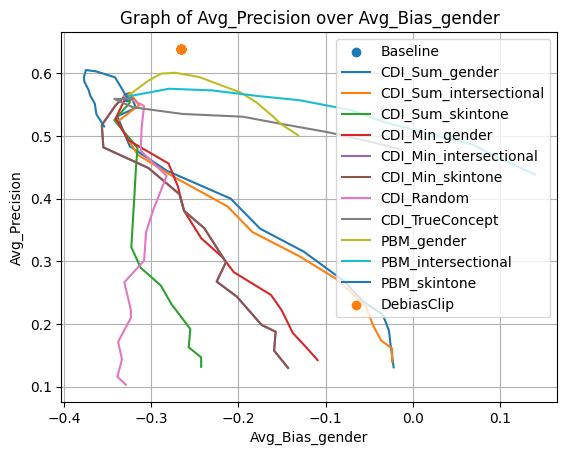

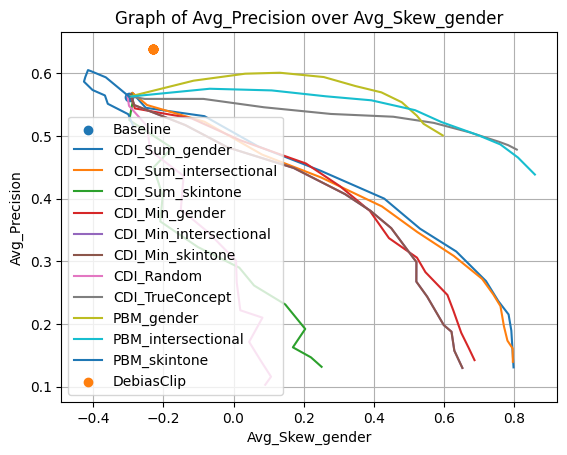

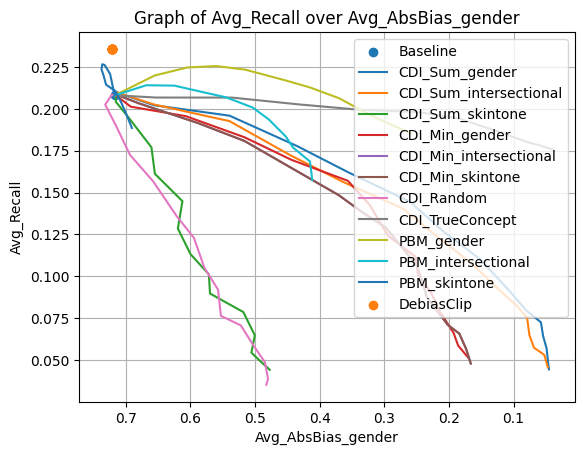

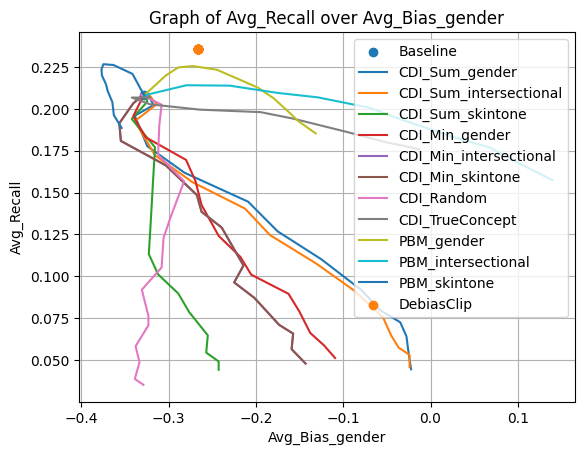

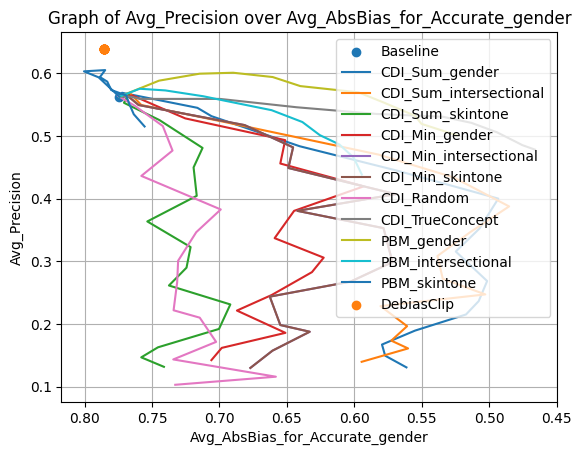

In [36]:
method_names = ['Baseline', 'DebiasClip', "CDI_Sum_gender"]
method_names = df2['name'].unique()

for k in [10, 25, 50, 100]:
    plot_across_tol(df2, 25, method_names, 'Avg_AbsBias_gender', 'Avg_Precision', reverse_x=True)
    plot_across_tol(df2, 25, method_names, 'Avg_Bias_gender', 'Avg_Precision', reverse_x=False)
    plot_across_tol(df2, 25, method_names, 'Avg_Skew_gender', 'Avg_Precision', reverse_x=False)
    plot_across_tol(df2, 25, method_names, 'Avg_AbsBias_gender', 'Avg_Recall', reverse_x=True)
    plot_across_tol(df2, 25, method_names, 'Avg_Bias_gender', 'Avg_Recall', reverse_x=False)
    plot_across_tol(df2, 25, method_names, 'Avg_AbsBias_for_Accurate_gender', 'Avg_Precision', reverse_x=True)